In [21]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import concatenate
from math import sqrt
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
import joblib
import os

from tensorflow.python.util import deprecation
deprecation._PRINT_DEPRECATION_WARNINGS = False


In [22]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

In [23]:
def to_supervised(data, n_input, n_out=1):
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #X.append(data[in_start:in_end, :])
            #y.append(data[in_end:out_end, 0])
            X.append(data[in_start:in_end,0])
            y.append(data[in_end:out_end,0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [57]:
def model_fit(train, config, i):
    #config
    n_input, n_nodes, n_epochs, n_batch = config
    #data preparation
    train_x, train_y = to_supervised(train, n_input)    
    # reshape from [samples, timesteps] into [samples, timesteps, features]
    train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
    n_features = 1
    # define model
    model = Sequential()
    model.add(LSTM(n_nodes, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(n_nodes, activation='relu'))
#    model.add(Dropout(0.15)) 
    model.add(Dense(1)) 
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    #model.compile(optimizer='adam', loss='mse')
    # fit model
    history = model.fit(train_x, train_y, epochs=n_epochs, batch_size=n_batch ,verbose=1, shuffle=False)

    # plot history
    pyplot.plot(history.history['loss'], label='train')
    #pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    pyplot.savefig('loss'+ str(i)+'.png')
    return model

In [25]:
def model_predict(model, train, test, config):
    n_input,_,_,_= config
    #data test preparation   
    history = [x for x in train[-n_input:]]
#    test_x, test_y = to_supervised(history, n_input, n_out)
#    x_input = array(test_x[0]).reshape((1, n_input, 1))
    predictions = list()
    # forecast
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
        #print("\rProcessing file {} ({}%)".format(i+1, 100*(i+1)//len(test)),sep=' ', end='', flush = True)
    predictions = array(predictions)    
    return predictions, test

In [26]:
# make a forecast
def forecast(model, history, n_input):
    data = array(history)
    # retrieve last observations for input data
    input_x = data[-n_input:, :]
    # reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

In [27]:
#load dataset, Time(UTC),prs(m),rad(m)
df = pd.read_csv('data1m.csv',sep=',', header=0, index_col=0, squeeze=True, parse_dates=True)
#non-null object to float64
df['prs(m)'] = pd.to_numeric(df['prs(m)'], errors='coerce')
#prs(m) looks more stable
df.drop(df.columns[[1]], axis=1, inplace=True)

In [28]:
s = df.interpolate()

In [29]:
values = s.values

#Future label encoder
#encoder = LabelEncoder()
#Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [45]:
train_size = int(len(df) * 0.95)
test_size = len(df) - train_size
#60*24 daily ~ 1440 measurements
#changing the n_test, change the train size

#7 days for ALL (?) = 60*24*7 = 10080
#60*8 = 480
n_test = test_size

train , test = train_test_split(scaled, n_test)
print(len(train), len(test))
test=test[:480]
#timesteps for predictions
pred_index= df.index[train_size:train_size+480]
print("Forecasting "+ str(len(test)/60) + " hrs ->"+ str(len(test)))

43026 2265
Forecasting 8.0 hrs ->480


In [47]:
def models_generator(configs, train, test, scaler, pred_index):
    for i in range(len(configs)):
        
        config = configs[i]
        filename = 'config' + str(i) + '.model'
        
        ##save/load checkpoint
        print( str(i) + "\nFitting config "+ str(config))
        model = model_fit(train, config,i)
        joblib.dump(model, filename)

        loaded_model = joblib.load(filename)

        #forecast
        predictions_inv, real_inv = model_predict(loaded_model, train, test , config)
        
        #invert scaling prediction
        predictions = scaler.inverse_transform(predictions_inv)
        #saving predictions
        prediction = pd.DataFrame(predictions, index = pred_index, columns=['predictions']).to_csv('predictions' + str(i) +'.csv')
        
        #inverser for metrics 
        test1 = scaler.inverse_transform(test)
        mse = mean_squared_error(test1, predictions)
        print("mse = "+ str(sqrt(mse)) + "\n\n")

    #data set inverse
    train = scaler.inverse_transform(train)
    test = scaler.inverse_transform(test)

    #invert scaling actual
    real_inv = real_inv.reshape((len(real_inv), 1))
    real = scaler.inverse_transform(real_inv)
   
    
    #plotting predictions
    #prediction_plotter(predictions, i)
    
    return

In [54]:
# create a list of configs to try
def model_configs():
    # define scope of configs
    n_input = [2,3,4,5]
    n_nodes = [2,3,4,5,6,7,8,9,10]
    n_epochs = [5,10]
    n_batch = [480]
    # create configs
    configs = list()
    for i in n_input:
        for j in n_nodes:
            for k in n_epochs:
                for l in n_batch:
                    cfg = [i, j, k, l]
                    configs.append(cfg)
    print('Total configs: %d' % len(configs))
    return configs

In [55]:
configs_lst = model_configs()

Total configs: 72


0
Fitting config [2, 2, 5, 480]
Epoch 1/5
43024/43024 [==============================] - 44s 1ms/step - loss: 0.4326 - acc: 2.3243e-05
Epoch 2/5
43024/43024 [==============================] - 2s 46us/step - loss: 0.3147 - acc: 2.3243e-05
Epoch 3/5
43024/43024 [==============================] - 2s 46us/step - loss: 0.2356 - acc: 2.3243e-05
Epoch 4/5
43024/43024 [==============================] - 2s 47us/step - loss: 0.1734 - acc: 2.3243e-05
Epoch 5/5
43024/43024 [==============================] - 2s 47us/step - loss: 0.1257 - acc: 2.3243e-05: 1s - lo
mse = 1.1009137090740924


1
Fitting config [2, 2, 10, 480]
Epoch 1/10
43024/43024 [==============================] - 46s 1ms/step - loss: 0.4115 - acc: 2.3243e-05
Epoch 2/10
43024/43024 [==============================] - 2s 48us/step - loss: 0.3116 - acc: 2.3243e-05
Epoch 3/10
43024/43024 [==============================] - 2s 52us/step - loss: 0.2321 - acc: 2.3243e-05
Epoch 4/10
43024/43024 [==============================] - 2s 55us/step -

43024/43024 [==============================] - 60s 1ms/step - loss: 0.4127 - acc: 2.3243e-05
Epoch 2/10
43024/43024 [==============================] - 2s 53us/step - loss: 0.3118 - acc: 2.3243e-05: 0s - loss: 0.3212 - acc: 2.81
Epoch 3/10
43024/43024 [==============================] - 2s 58us/step - loss: 0.2323 - acc: 2.3243e-05
Epoch 4/10
43024/43024 [==============================] - 2s 55us/step - loss: 0.1702 - acc: 2.3243e-05: 0s - loss: 0.1763 - acc: 2.8
Epoch 5/10
43024/43024 [==============================] - 2s 54us/step - loss: 0.1229 - acc: 2.3243e-05
Epoch 6/10
43024/43024 [==============================] - 2s 53us/step - loss: 0.0877 - acc: 2.3243e-05: 0s - loss: 0.0913 - acc: 2.7
Epoch 7/10
43024/43024 [==============================] - 2s 53us/step - loss: 0.0623 - acc: 2.3243e-05
Epoch 8/10
43024/43024 [==============================] - 2s 52us/step - loss: 0.0444 - acc: 2.3243e-05: 0s - loss: 0.0503 
Epoch 9/10
43024/43024 [==============================] - 2s 50us/st

43024/43024 [==============================] - 3s 60us/step - loss: 0.2824 - acc: 2.3243e-05: 2 - ETA: 0s - loss: 0.2833 - acc: 2.3674e-0
Epoch 3/10
43024/43024 [==============================] - 3s 71us/step - loss: 0.1009 - acc: 2.3243e-05
Epoch 4/10
43024/43024 [==============================] - 3s 62us/step - loss: 0.0074 - acc: 4.6486e-05: 0s - loss: 0.0075 - acc: 5.0201
Epoch 5/10
43024/43024 [==============================] - 3s 62us/step - loss: 0.0049 - acc: 4.6486e-05: 1s - los - ETA: 0s - loss: 0.0049 - acc: 4.6816e-0
Epoch 6/10
43024/43024 [==============================] - 3s 63us/step - loss: 0.0042 - acc: 4.6486e-05: 1s - loss: 0.0054 - acc: 9.6899e - ETA: 1s - loss: 0.0052 - acc: - ETA: 0s - loss: 0.0047 - acc:
Epoch 7/10
43024/43024 [==============================] - 3s 67us/step - loss: 0.0030 - acc: 4.6486e-05: 1s - loss: 0.0043 - acc: 1.0684e - ETA: 1s - loss: 0
Epoch 8/10
43024/43024 [==============================] - 3s 64us/step - loss: 0.0017 - acc: 4.6486e-05: 

43023/43023 [==============================] - 3s 61us/step - loss: 7.7253e-04 - acc: 4.6487e-05: 2s - loss: 0.0011 - acc: 0.0000e+0 - ETA: 2s - loss: 0.0012 - acc:  - ETA: 1s - 
Epoch 10/10
43023/43023 [==============================] - 3s 61us/step - loss: 5.6066e-04 - acc: 4.6487e-05: 0s - loss: 5.7005e-04 - acc: 5.1440e - ETA: 0s - loss: 5.5706e-04 - acc: 4.7893e-
mse = 0.06145985220163702


24
Fitting config [3, 5, 5, 480]
Epoch 1/5
43023/43023 [==============================] - 85s 2ms/step - loss: 0.2890 - acc: 2.3243e-05TA: 14:06 - loss: 0.47 - ETA: 1:27 - loss: 0.3753 - acc: 4 - ETA: 48s - loss: 0.3497 - acc - ETA: 25s - loss: 0.3283 
Epoch 2/5
43023/43023 [==============================] - 3s 62us/step - loss: 0.0384 - acc: 2.3243e-05: 2s - loss:  - ETA: 0s - loss: 0.0562 - acc: 3.53 - ETA: 0s - loss: 0.0476 - acc: 2.9343e - ETA: 0s - loss: 0.0441 - acc: 2.70
Epoch 3/5
43023/43023 [==============================] - 3s 62us/step - loss: 0.0040 - acc: 4.6487e-05: 1s - loss: 0.0

43023/43023 [==============================] - 2s 53us/step - loss: 0.0028 - acc: 4.6487e-05: 0s - loss: 0.0027 - acc: 4.6816e-0
Epoch 5/5
43023/43023 [==============================] - 2s 54us/step - loss: 0.0024 - acc: 4.6487e-05
mse = 0.11020128595154116


31
Fitting config [3, 8, 10, 480]
Epoch 1/10
43023/43023 [==============================] - 78s 2ms/step - loss: 0.3309 - acc: 2.3243e-05
Epoch 2/10
43023/43023 [==============================] - 2s 55us/step - loss: 0.0518 - acc: 2.3243e-05
Epoch 3/10
43023/43023 [==============================] - 2s 55us/step - loss: 0.0039 - acc: 4.6487e-05
Epoch 4/10
43023/43023 [==============================] - 2s 56us/step - loss: 0.0031 - acc: 4.6487e-05
Epoch 5/10
43023/43023 [==============================] - 2s 55us/step - loss: 0.0026 - acc: 4.6487e-05
Epoch 6/10
43023/43023 [==============================] - 2s 56us/step - loss: 0.0021 - acc: 4.6487e-05: 2s - loss: 0.0033 - acc: 0.0000e+ - ETA
Epoch 7/10
43023/43023 [=================

43022/43022 [==============================] - 3s 66us/step - loss: 9.2087e-04 - acc: 4.6488e-05
Epoch 5/10
43022/43022 [==============================] - 3s 65us/step - loss: 7.6311e-04 - acc: 4.6488e-05
Epoch 6/10
43022/43022 [==============================] - 3s 65us/step - loss: 6.1251e-04 - acc: 4.6488e-05
Epoch 7/10
43022/43022 [==============================] - 3s 66us/step - loss: 4.7724e-04 - acc: 4.6488e-05
Epoch 8/10
43022/43022 [==============================] - 3s 65us/step - loss: 3.6275e-04 - acc: 4.6488e-05
Epoch 9/10
43022/43022 [==============================] - 3s 65us/step - loss: 2.7158e-04 - acc: 4.6488e-05
Epoch 10/10
43022/43022 [==============================] - 3s 65us/step - loss: 2.0341e-04 - acc: 4.6488e-05
mse = 0.042047755922502074


40
Fitting config [4, 4, 5, 480]
Epoch 1/5
43022/43022 [==============================] - 92s 2ms/step - loss: 0.3584 - acc: 2.3244e-05
Epoch 2/5
43022/43022 [==============================] - 3s 64us/step - loss: 0.1493 - ac

43022/43022 [==============================] - 3s 69us/step - loss: 0.0083 - acc: 4.6488e-05
Epoch 4/5
43022/43022 [==============================] - 3s 69us/step - loss: 0.0054 - acc: 4.6488e-05
Epoch 5/5
43022/43022 [==============================] - ETA: 0s - loss: 0.0045 - acc: 4.6816e-0 - 3s 68us/step - loss: 0.0046 - acc: 4.6488e-05
mse = 0.15119081477502483


49
Fitting config [4, 8, 10, 480]
Epoch 1/10
43022/43022 [==============================] - 109s 3ms/step - loss: 0.2008 - acc: 2.3244e-05
Epoch 2/10
43022/43022 [==============================] - 3s 70us/step - loss: 0.0087 - acc: 4.6488e-05
Epoch 3/10
43022/43022 [==============================] - 3s 71us/step - loss: 0.0030 - acc: 4.6488e-05
Epoch 4/10
43022/43022 [==============================] - 3s 73us/step - loss: 0.0015 - acc: 4.6488e-05
Epoch 5/10
43022/43022 [==============================] - 3s 69us/step - loss: 2.4295e-04 - acc: 4.6488e-05
Epoch 6/10
43022/43022 [==============================] - 3s 69us/step -

43021/43021 [==============================] - 4s 85us/step - loss: 0.0322 - acc: 2.3244e-05
Epoch 10/10
43021/43021 [==============================] - 4s 84us/step - loss: 0.0243 - acc: 2.3244e-05
mse = 0.422919213588603


58
Fitting config [5, 4, 5, 480]
Epoch 1/5
43021/43021 [==============================] - 128s 3ms/step - loss: 0.4869 - acc: 2.3244e-05
Epoch 2/5
43021/43021 [==============================] - 4s 86us/step - loss: 0.2167 - acc: 2.3244e-05
Epoch 3/5
43021/43021 [==============================] - 4s 84us/step - loss: 0.0128 - acc: 4.6489e-05
Epoch 4/5
43021/43021 [==============================] - 4s 86us/step - loss: 0.0045 - acc: 4.6489e-05
Epoch 5/5
43021/43021 [==============================] - 4s 84us/step - loss: 0.0040 - acc: 4.6489e-05
mse = 0.14700481577744406


59
Fitting config [5, 4, 10, 480]
Epoch 1/10
43021/43021 [==============================] - 131s 3ms/step - loss: 0.3578 - acc: 2.3244e-05
Epoch 2/10
43021/43021 [==============================] - 4s

43021/43021 [==============================] - 4s 101us/step - loss: 0.0044 - acc: 4.6489e-05
Epoch 3/10
43021/43021 [==============================] - 5s 109us/step - loss: 0.0018 - acc: 4.6489e-05
Epoch 4/10
43021/43021 [==============================] - 4s 104us/step - loss: 9.2748e-04 - acc: 4.6489e-05
Epoch 5/10
43021/43021 [==============================] - 5s 108us/step - loss: 3.5611e-04 - acc: 4.6489e-05 1s - loss: 4.520
Epoch 6/10
43021/43021 [==============================] - 5s 114us/step - loss: 1.4940e-04 - acc: 4.6489e-05
Epoch 7/10
43021/43021 [==============================] - 4s 102us/step - loss: 1.0622e-04 - acc: 4.6489e-05
Epoch 8/10
43021/43021 [==============================] - 4s 99us/step - loss: 8.9159e-05 - acc: 4.6489e-05
Epoch 9/10
43021/43021 [==============================] - 4s 100us/step - loss: 8.3587e-05 - acc: 4.6489e-05 0s - loss: 8.7447e-05 - acc:
Epoch 10/10
43021/43021 [==============================] - 4s 100us/step - loss: 8.0569e-05 - acc: 4.6

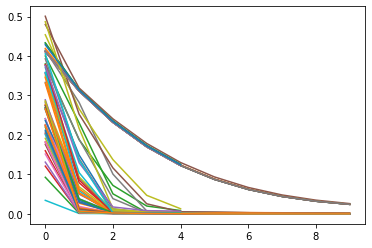

In [58]:
models_generator(configs_lst, train, test, scaler, pred_index)

In [15]:
def prediction_plotter(predictions, i=0):
    plt.rcParams["figure.figsize"] = (200,20)
    plt.plot(test, marker='.', label="true")
    plt.plot(predictions, 'r', label="prediction")
    plt.ylabel('Sea lvl')
    plt.xlabel('Time Step')
    plt.legend()
    plt.show();
    plt.savefig('predictions'+ str(i)+'_1m_cnfgA.png')
    return

In [16]:
def create_model(neurons= 5, n_input= 2, n_features=1):
    # create model
    model = Sequential()
    model.add(LSTM(neurons, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(neurons, activation='relu'))
#    model.add(Dropout(0.15)) 
    model.add(Dense(1)) 
    # Compile model
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [17]:
def grid_search(X, Y, n_input):
    model = KerasClassifier(build_fn=create_model(n_input), verbose=0)
    # define the grid search parameters
    batch_size = [2, 10, 20, 40, 60, 80, 100, 200, 512, 1024, 1440]
    epochs = [5]
    neurons= [1,3,4,5,10,15,20]
    #
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
    grid_result = grid.fit(X, Y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print("%f (%f) with: %r" % (mean, stdev, param))
    return

In [18]:
def input_loop(train):
    for i in range(2,10):
        train_x, train_y = to_supervised(train, n_input=i)  
        train_x = train_x.reshape((train_x.shape[0], train_x.shape[1], 1))
        print("Grid search w/"+ str(i) +" inputs")
        grid_search(train_x,train_y,i)
    return